In [1]:
import cv2,os

data_path='dataset'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels)) #empty dictionary

print(label_dict)
print(categories)
print(labels)

{'with mask': 0, 'without mask': 1}
['with mask', 'without mask']
[0, 1]


In [2]:
img_size=100
data=[]
target=[]


for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
            #Coverting the image into gray scale
            resized=cv2.resize(gray,(img_size,img_size))
            #resizing the gray scale into 50x50, since we need a fixed common size for all the images in the dataset
            data.append(resized)
            target.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)

        except Exception as e:
            print('Exception:',e)
            #if any exception rasied, the exception will be printed here. And pass to the next image

In [3]:
import numpy as np

data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)

from keras.utils import np_utils

new_target=np_utils.to_categorical(target)

In [4]:
np.save('data',data)
np.save('target',new_target)

In [5]:
import numpy as np

data=np.load('data.npy')
target=np.load('target.npy')

#loading the save numpy arrays in the previous code

In [6]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint

model=Sequential()

model.add(Conv2D(200,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The first CNN layer followed by Relu and MaxPooling layers

model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The second convolution layer followed by Relu and MaxPooling layers

model.add(Flatten())
model.add(Dropout(0.5))
#Flatten layer to stack the output convolutions from second convolution layer
model.add(Dense(50,activation='relu'))
#Dense layer of 64 neurons
model.add(Dense(2,activation='softmax'))
#The Final layer with two outputs for two categories

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [7]:
from sklearn.model_selection import train_test_split

train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.1)

In [8]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history=model.fit(train_data,train_target,epochs=20,callbacks=[checkpoint],validation_split=0.2)

Epoch 1/20
31/31 [==============================] - 51s 2s/step - loss: 0.7286 - accuracy: 0.5091 - val_loss: 0.6732 - val_accuracy: 0.5605
INFO:tensorflow:Assets written to: model-001.model\assets
Epoch 2/20
31/31 [==============================] - 46s 1s/step - loss: 0.6793 - accuracy: 0.5707 - val_loss: 0.6225 - val_accuracy: 0.6573
INFO:tensorflow:Assets written to: model-002.model\assets
Epoch 3/20
31/31 [==============================] - 47s 2s/step - loss: 0.5318 - accuracy: 0.7273 - val_loss: 0.4810 - val_accuracy: 0.7823
INFO:tensorflow:Assets written to: model-003.model\assets
Epoch 4/20
31/31 [==============================] - 49s 2s/step - loss: 0.4237 - accuracy: 0.8192 - val_loss: 0.3820 - val_accuracy: 0.8185
INFO:tensorflow:Assets written to: model-004.model\assets
Epoch 5/20
31/31 [==============================] - 47s 2s/step - loss: 0.3282 - accuracy: 0.8697 - val_loss: 0.3791 - val_accuracy: 0.8387
INFO:tensorflow:Assets written to: model-005.model\assets
Epoch 6/20

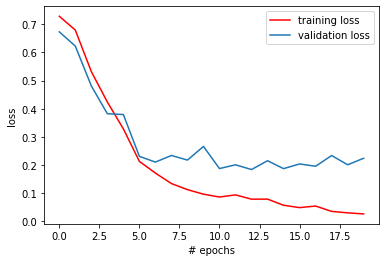

In [9]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

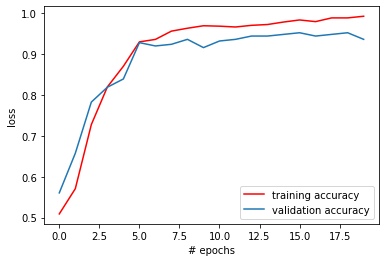

In [10]:
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [11]:
print(model.evaluate(test_data,test_target))

5/5 [==============================] - 2s 343ms/step - loss: 0.1295 - accuracy: 0.9565
[0.12948985397815704, 0.95652174949646]


In [12]:
from keras.models import load_model
import cv2
import numpy as np

In [13]:
model = load_model('model-017.model')

face_clsfr=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

source=cv2.VideoCapture(2)

labels_dict={0:'MASK',1:'NO MASK'}
color_dict={0:(0,255,0),1:(0,0,255)}

In [15]:
while(True):
    cap = cv2.VideoCapture(0)

    ret,img=cap.read()
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_clsfr.detectMultiScale(gray,1.3,5)  

    for (x,y,w,h) in faces:
    
        face_img=gray[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(100,100))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,100,100,1))
        result=model.predict(reshaped)

        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
        
    cv2.imshow('LIVE',img)
    key=cv2.waitKey(1)
    
    if(key==27):
        break
        
cv2.destroyAllWindows()
source.release()

KeyboardInterrupt: 